In [2]:
!pip install pyglyph
!pip install deap
!pip install graphviz
import Fresnel_1layer_1variable

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [9]:
from functools import partial

import deap.gp
import deap.tools
import numpy as np
import sympy
from sympy import *
from glyph import gp
from glyph.assessment import const_opt
from glyph.utils import Memoize
from glyph.utils.numeric import nrmse,rmse, silent_numpy
import random



pset = gp.numpy_primitive_set(arity=1,categories=("algebraic","exponential","symc"))
pset.addTerminal(1j,"i")
Individual = gp.Individual(pset=pset)
R_target = Fresnel_1layer_1variable.calculate_R_coeff().get('R')
wave = np.linspace(200,1000,1000)
e1=114.96
d=e1/wave
print(R_target)

def error(ind, *args):
    f = gp.individual.numpy_phenotype(ind)
    y = R_target
    yhat = f(d, *args) 

    if np.isscalar(yhat):
        yhat = np.ones_like(y) * yhat
    #As we have R = |r|²
    Y = y
    YHAT = np.abs(yhat)**2
    return rmse(Y,YHAT)

@Memoize
def measure(ind):
    popt, err_opr = const_opt(error, ind)
    ind.popt = popt
    return err_opr, len(ind)


def update_fitness(population, map=map):
    invalid = [p for p in population if not p.fitness.valid]
    fitnesses = map(measure, invalid)
    for ind, fit in zip(invalid, fitnesses):
        ind.fitness.values = fit
    return population

[1.74482677e-01 1.78469514e-01 1.82310217e-01 1.86003924e-01
 1.89550148e-01 1.92948739e-01 1.96199853e-01 1.99303916e-01
 2.02261602e-01 2.05073801e-01 2.07741597e-01 2.10266245e-01
 2.12649151e-01 2.14891855e-01 2.16996009e-01 2.18963369e-01
 2.20795774e-01 2.22495139e-01 2.24063439e-01 2.25502704e-01
 2.26815006e-01 2.28002451e-01 2.29067173e-01 2.30011329e-01
 2.30837090e-01 2.31546638e-01 2.32142160e-01 2.32625848e-01
 2.32999891e-01 2.33266474e-01 2.33427776e-01 2.33485967e-01
 2.33443208e-01 2.33301646e-01 2.33063417e-01 2.32730641e-01
 2.32305425e-01 2.31789859e-01 2.31186018e-01 2.30495960e-01
 2.29721729e-01 2.28865349e-01 2.27928831e-01 2.26914167e-01
 2.25823336e-01 2.24658299e-01 2.23421003e-01 2.22113378e-01
 2.20737342e-01 2.19294795e-01 2.17787627e-01 2.16217711e-01
 2.14586910e-01 2.12897071e-01 2.11150032e-01 2.09347617e-01
 2.07491637e-01 2.05583896e-01 2.03626182e-01 2.01620277e-01
 1.99567950e-01 1.97470959e-01 1.95331056e-01 1.93149979e-01
 1.90929459e-01 1.886712

In [ ]:
pop_size = 800

mate = deap.gp.cxOnePoint
expr_mut = partial(deap.gp.genFull, min_=1, max_=5)
mutate = partial(deap.gp.mutUniform, expr=expr_mut, pset=Individual.pset)
algorithm = gp.algorithms.AgeFitness(mate, mutate, deap.tools.selNSGA2, Individual.create_population)

pop = update_fitness(Individual.create_population(pop_size))
for gen in range(40):
    pop = algorithm.evolve(pop)
    pop = update_fitness(pop)
    best = deap.tools.selBest(pop, 1)[0]
    print(gp.individual.simplify_this(best), best.fitness.values)
    

In [14]:
from sympy import *
from sympy import sympify
import pickle

x, y, z, t = symbols('x y z t')
locals = {
  "Add": Add,
  "Mul": Mul,
  "Sub": Lambda((x, y), x - y),
  "Div": Lambda((x, y), x/y),
  "Sqrt":Lambda(x,sqrt(x)),
  "Exp": Lambda(x,exp(x)),
  "Neg": Lambda(x, -x),
  "log": Lambda(x,log(x))
}
#all_best = deap.tools.selBest(pop, 25)
#print(all_best)
sympify(str(gp.individual.simplify_this(best)),locals=locals)
#for element in all_best:
  #print(sympify(str(gp.individual.simplify_this(element)),locals=locals)) 
  #sympify(str(gp.individual.simplify_this(best)),locals=locals) #FINAL RESULT

Symc*log(-Symc**2*(exp(Symc) + log(i))*(-Symc*i - Symc*x_0/(i + x_0) + Symc + Symc/i + x_0 - exp(Symc))*exp(x_0 + 1)/((-Symc + i)*(exp(i*x_0) + (Symc + x_0)*log(x_0/Symc)/(-Symc + x_0))) + Symc)

In [15]:
from sympy import *
from sympy import sympify
import pickle
with open('best_d_params_4.pkl', 'wb') as outp:
    pickle.dump(best, outp, pickle.HIGHEST_PROTOCOL)
popt,_=const_opt(error, best)
f = open("./results_1_layer_d_params.txt", "a")
f.write(f"best_d_params_4\n\n{best}\n\n fitness and length : {best.fitness.values}\n - constant optimization : {popt} ")
f.close()

Text(0, 0.5, 'R')

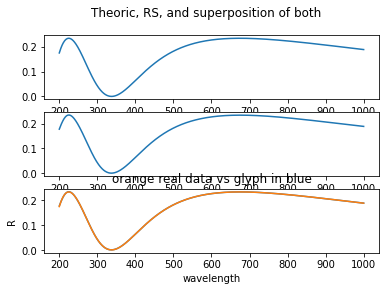

In [10]:

import pickle
import matplotlib.pyplot as plt
best = pickle.load( open( "best_d_params_4.pkl", "rb" ) )

f = gp.individual.numpy_phenotype(best)

popt,_=const_opt(error, best) 
r = f(d,*popt)
fig, axs = plt.subplots(3)
fig.suptitle('Theoric, RS, and superposition of both')
axs[0].plot(wave, R_target)
axs[1].plot(wave,np.abs(r)**2)
axs[2].plot(wave,np.abs(r)**2)
axs[2].plot(wave, R_target)

plt.title('orange real data vs glyph in blue')
plt.xlabel('wavelength')
plt.ylabel('R')

Text(0, 0.5, 'R')

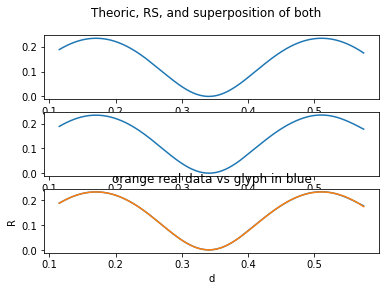

In [4]:
import pickle
import matplotlib.pyplot as plt
best = pickle.load( open( "best_d_params_4.pkl", "rb" ) )

f = gp.individual.numpy_phenotype(best)

popt,_=const_opt(error, best) 
r = f(d,*popt)
fig, axs = plt.subplots(3)
fig.suptitle('Theoric, RS, and superposition of both')
axs[0].plot(d, R_target)
axs[1].plot(d,np.abs(r)**2)
axs[2].plot(d,np.abs(r)**2)
axs[2].plot(d, R_target)

plt.title('orange real data vs glyph in blue')
plt.xlabel('d')
plt.ylabel('R')